3.2292999999999997e-06


C:\Users\iamga\AppData\Local\Temp\ipykernel_39492\486013277.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9,3))


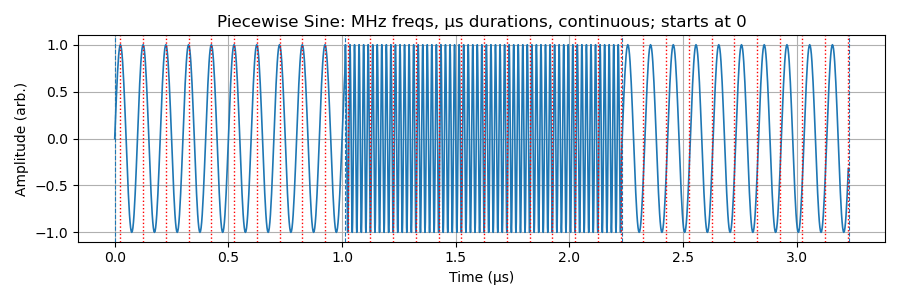

In [22]:
import numpy as np
import matplotlib.pyplot as plt

MASK2PI = 2*np.pi

def plot_piecewise_sine(freqs_MHz, times_us, phases_deg=None, force_start_at_zero=True):
    freqs_MHz = list(freqs_MHz)
    times_us = list(times_us)
    n = len(freqs_MHz)
    if len(times_us) != n:
        raise ValueError("freqs_MHz and times_us must have the same length")
    if phases_deg is None:
        phases_deg = [0.0]*n
    else:
        phases_deg = list(phases_deg)
        if len(phases_deg) != n:
            raise ValueError("phases_deg length must match freqs_MHz")
    if force_start_at_zero:
        phases_deg[0] = 0.0

    freqs_Hz = [f*1e6 for f in freqs_MHz]
    durs_s = [t*1e-6 for t in times_us]

    t_all = []
    y_all = []

    t0 = 0.0
    phi_cum = 0.0
    boundaries = [0.0]

    for f, dur, phi_deg in zip(freqs_Hz, durs_s, phases_deg):
        # choose samples ~40 points per cycle, at least 200 samples per segment
        cycles = max(f*dur, 1.0)
        m = int(max(200, np.ceil(40*cycles)))
        t_seg = np.linspace(0.0, dur, m, endpoint=False)
        theta0 = (phi_cum + np.deg2rad(phi_deg)) % MASK2PI
        y_seg = np.sin(2*np.pi*f*t_seg + theta0)
        t_all.append(t0 + t_seg)
        y_all.append(y_seg)
        phi_cum = (phi_cum + 2*np.pi*f*dur) % MASK2PI
        t0 += dur
        boundaries.append(t0)

    t = np.concatenate(t_all)
    y = np.concatenate(y_all)

    plt.figure(figsize=(9,3))
    plt.plot(t*1e6, y, linewidth=1.2)
    for bx in boundaries:
        plt.axvline(bx*1e6, linestyle="--", linewidth=0.8)

    print(t0)
    for x_peaks in np.arange(0.025e-6, t0, 0.1e-6):
        plt.axvline(x_peaks*1e6, color='red', linestyle=':', linewidth=1)
    plt.xlabel("Time (µs)")
    plt.ylabel("Amplitude (arb.)")
    plt.title("Piecewise Sine: MHz freqs, µs durations, continuous; starts at 0")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# demo
plot_piecewise_sine(freqs_MHz=[10, 50, 10],
                    times_us=[1.0123, 1.217, 1],
                    phases_deg=[0, 0, 0],
                    force_start_at_zero=False)


In [1]:
%matplotlib widget


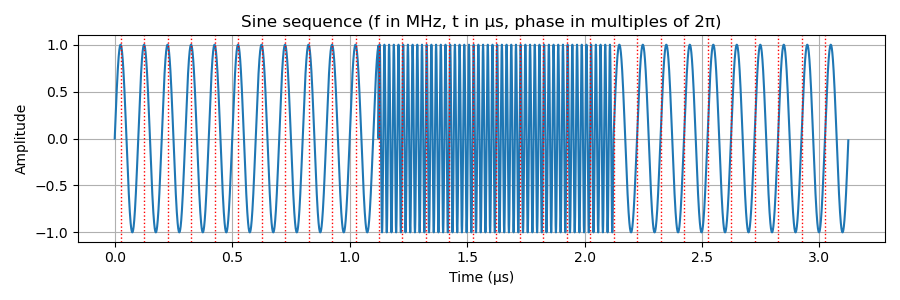

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def synth_sequence(freqs_mhz, phases_2pi, durations_us, sample_rate_mhz=3200):
    freqs_mhz=np.asarray(freqs_mhz,dtype=float)
    phases_2pi=np.asarray(phases_2pi,dtype=float)
    durations_us=np.asarray(durations_us,dtype=float)
    assert len(freqs_mhz)==len(phases_2pi)==len(durations_us)
    starts_us=np.concatenate(([0.0],np.cumsum(durations_us)[:-1]))
    dt_us=1.0/sample_rate_mhz
    t_segments=[]
    y_segments=[]
    phase_corr=0.0
    for f,phi2pi,dur,t0 in zip(freqs_mhz,phases_2pi,durations_us,starts_us):
        n=max(1,int(np.round(dur/dt_us)))
        t=t0+np.arange(n)*dt_us
        y=np.sin(2*np.pi*(f*(t-t0)+phi2pi + phase_corr))
        t_segments.append(t)
        y_segments.append(y)
    t_us=np.concatenate(t_segments)
    y=np.concatenate(y_segments)
    return t_us,y


freqs_mhz=[10,50,10]
phases_2pi=[0,0,0.0]
durations_us=[1.123,1.0,1]
t_us,y=synth_sequence(freqs_mhz,phases_2pi,durations_us,sample_rate_mhz=3200)
plt.figure(figsize=(9,3))
plt.plot(t_us,y)
for x_peaks in np.arange(0.025, sum(durations_us), 0.1):
    plt.axvline(x_peaks, color='red', linestyle=':', linewidth=1)
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")
plt.title("Sine sequence (f in MHz, t in µs, phase in multiples of 2π)")
plt.grid(True)
plt.tight_layout()
plt.show()


50.0 1.0
50.0
10.0 2.0
20.0


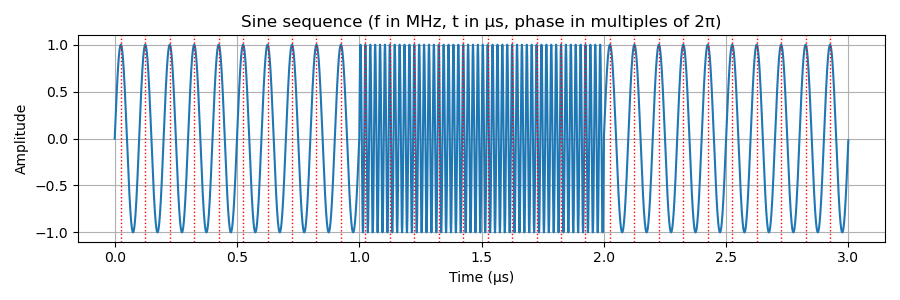

In [75]:
def synth_sequence(freqs_mhz, phases_2pi, durations_us, sample_rate_mhz=100.0):
    freqs_mhz=np.asarray(freqs_mhz,dtype=float)
    phases_2pi=np.asarray(phases_2pi,dtype=float)
    durations_us=np.asarray(durations_us,dtype=float)
    assert len(freqs_mhz)==len(phases_2pi)==len(durations_us)
    starts_us=np.concatenate(([0.0],np.cumsum(durations_us)[:-1]))
    dt_us=1.0/sample_rate_mhz
    t_segments=[]
    y_segments=[]
    phase_corr=0.0
    for i,(f,phi2pi,dur,t0) in enumerate(zip(freqs_mhz,phases_2pi,durations_us,starts_us)):
        n=max(1,int(np.round(dur/dt_us)))
        t=t0+np.arange(n)*dt_us
        y=np.sin(2*np.pi*(f*(t-t0)+phi2pi+phase_corr))
        t_segments.append(t)
        y_segments.append(y)
        if i<len(freqs_mhz)-1:
            print(freqs_mhz[i+1], sum(durations_us[:i+1]))
            phase_corr = freqs_mhz[i+1]*sum(durations_us[:i+1])
            print(phase_corr)
    t_us=np.concatenate(t_segments)
    y=np.concatenate(y_segments)
    return t_us,y

freqs_mhz=[10,50,10]
phases_2pi=[0,0,0]
durations_us=[1.0,1.0,1]
t_us,y=synth_sequence(freqs_mhz,phases_2pi,durations_us,sample_rate_mhz=3200)
plt.figure(figsize=(9,3))
plt.plot(t_us,y)
for x_peaks in np.arange(0.025, sum(durations_us), 0.1):
    plt.axvline(x_peaks, color='red', linestyle=':', linewidth=1)
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude")
plt.title("Sine sequence (f in MHz, t in µs, phase in mul" \
"tiples of 2π)")
plt.grid(True)
plt.tight_layout()
plt.show()